# Klasifikasi Teks dengan Transformers
Transformer bisa dianggap sebagai “lompatan besar” dalam dunia kecerdasan buatan. Model ini bukan hanya sekadar alat untuk klasifikasi teks, tetapi merupakan fondasi yang membuka jalan lahirnya sistem canggih seperti ChatGPT. Keistimewaannya terletak pada kemampuannya menangkap konteks secara global melalui mekanisme self-attention, sehingga model benar-benar “mengerti” relasi antar kata, frasa, bahkan paragraf panjang. Inilah yang membuat Transformer terasa begitu “wah”,  dia mampu melampaui keterbatasan CNN, RNN, atau LSTM yang sebelumnya menjadi standar. Dari kemampuan memahami teks sederhana, Transformer berkembang menjadi otak di balik model bahasa raksasa yang bisa berdialog, menjawab pertanyaan, hingga menghasilkan konten yang menyerupai tulisan manusia. Singkatnya, Transformer bukan hanya sekadar model, melainkan pondasi revolusi dalam pemrosesan bahasa alami.

# Import Library

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import spacy

tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Klasifikasi Teks: Menggunakan Transformers Encoder Block
- Transformers adalah model pembelajaran yang mendalam yang mengadopsi mekanisme perhatian diri, secara berbeda membobot pentingnya setiap bagian dari data input
- Mereka memegang potensi untuk memahami hubungan antara elemen berurutan yang jauh dari satu sama lain
- Mereka jauh lebih akurat
- Mereka memberikan perhatian yang sama untuk semua elemen dalam urutan

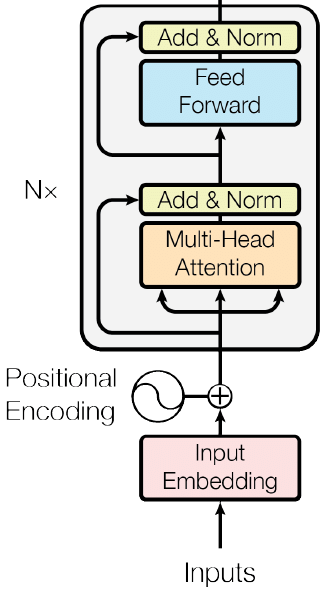

In [2]:
data1 = pd.read_json('C:/Users/LENOVO/Python/Sarcasm_Headlines_Dataset_v2.json', lines=True)
data2 = pd.read_json('C:/Users/LENOVO/Python/Sarcasm_Headlines_Dataset.json', lines=True)

In [3]:
data1 = data1[['headline','is_sarcastic']]
data2 = data2[['headline','is_sarcastic']]

data = pd.concat([data1,data2])
data.reset_index(drop=True, inplace=True)

In [4]:
data.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


# EDA dan Preprocessing Teks

## Memeriksa nilai yang hilang

In [5]:
data.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

## Menemukan keseimbangan/ketidakseimbangan kelas

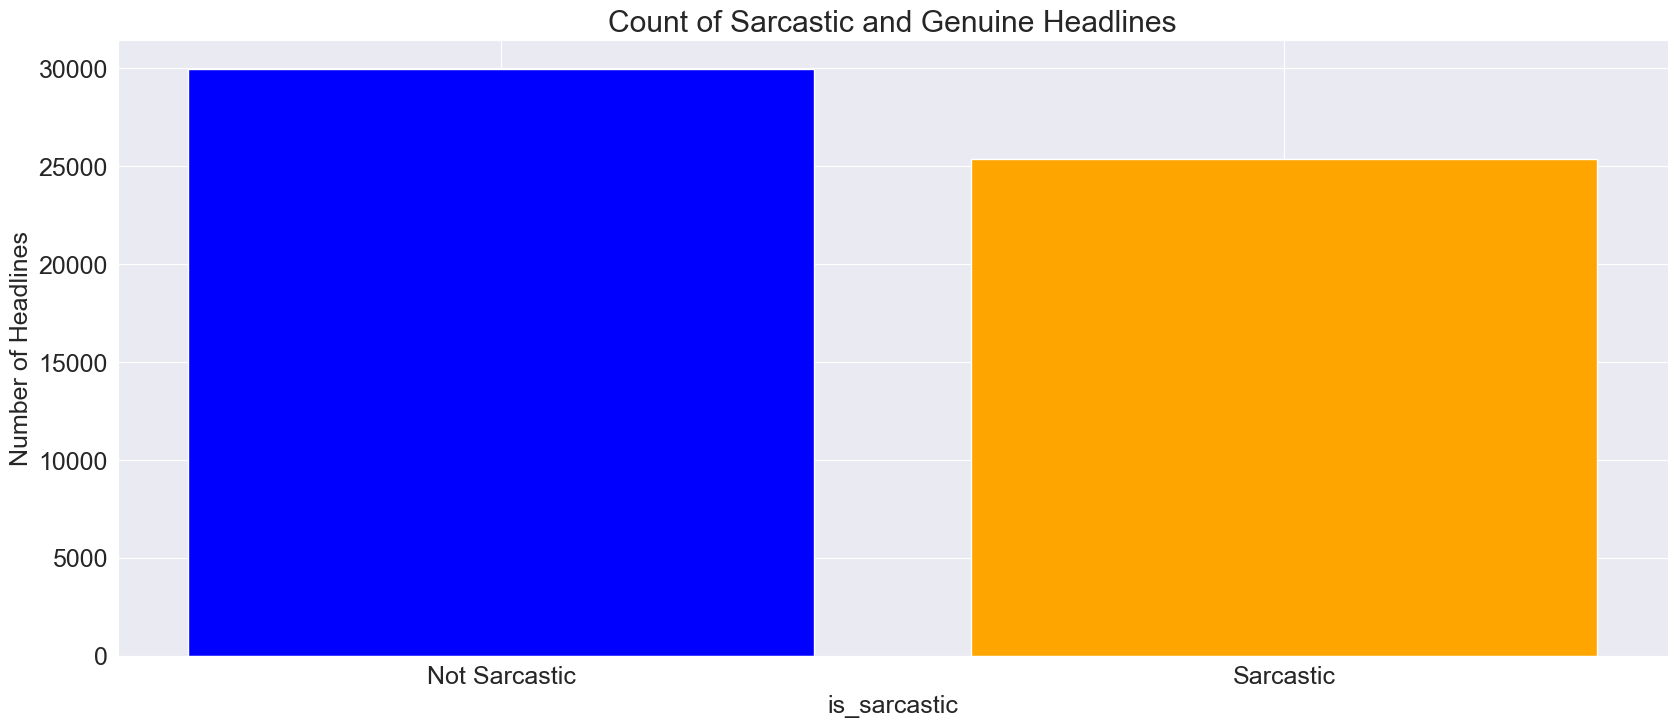

In [6]:
df_count = data.groupby('is_sarcastic').size().reset_index(name='count')
plt.bar(df_count['is_sarcastic'], df_count['count'], color=['blue', 'orange'])
plt.title('Count of Sarcastic and Genuine Headlines')
plt.xlabel('is_sarcastic')
plt.ylabel('Number of Headlines')
plt.xticks([0, 1], ['Not Sarcastic', 'Sarcastic'])
plt.show()

### Interpretasi
* Perbedaan jumlahnya tidak terlalu ekstrem, sehingga dataset ini relatif seimbang dan cukup baik untuk pelatihan model klasifikasi (tidak terlalu bias ke salah satu kelas).
* Artinya, model yang dibangun tidak akan terlalu terdorong ke salah satu label saja karena distribusi datanya masih cukup proporsional.

In [7]:
data['is_sarcastic'].value_counts()

is_sarcastic
0    29970
1    25358
Name: count, dtype: int64

Dataset relatif seimbang antara kedua kelas.

## Penghapusan Karakter Khusus
- Kita tidak akan menghapus angka dari data teks asli, mari kita analisis lebih lanjut jika berisi informasi yang relevan
- Kita dapat menemukan jenis entitas token dalam kalimat menggunakan Named Entity Recognition (NER), ini akan membantu kita mengidentifikasi jenis dan relevansi angka dalam data teks kita

In [8]:
stop_words = stopwords.words('english')
stop_words.remove('not')

def text_cleaning(x):

    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()

    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)

    return headline

In [9]:
def get_entities(x):
    entity = []
    text = spacy_eng(x)
    for word in text.ents:
        entity.append(word.label_)
    return ",".join(entity)

data['entity'] = data['headline'].progress_apply(get_entities)

100%|██████████| 55328/55328 [05:10<00:00, 178.05it/s]


In [11]:
nltk.download('wordnet')

data['clean_headline'] = data['headline'].apply(text_cleaning)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
data['sentence_length'] = data['clean_headline'].apply(lambda x: len(x.split()))
data

,headline,is_sarcastic,entity,clean_headline,sentence_length
0,thirtysomething scientists unveil doomsday clo...,1,CARDINAL,thirtysomething scientists unveil doomsday clo...,7
1,dem rep. totally nails why congress is falling...,0,"ORG,ORG",dem rep totally nail congress fall short gende...,10
2,eat your veggies: 9 deliciously different recipes,0,CARDINAL,eat veggies 9 deliciously different recipes,6
3,inclement weather prevents liar from getting t...,1,,inclement weather prevent liar get work,6
4,mother comes pretty close to using word 'strea...,1,,mother come pretty close use word stream corre...,8
...,...,...,...,...,...
55323,american politics in moral free-fall,0,NORP,american politics moral free fall,5
55324,america's best 20 hikes,0,"GPE,CARDINAL",america best 20 hike,4
55325,reparations and obama,0,,reparations obama,2
55326,israeli ban targeting boycott supporters raise...,0,NORP,israeli ban target boycott supporters raise al...,8


## Distribusi panjang berita utama
- Cari lebih panjang dari kalimat headline
- Biasanya berita utama tidak boleh lebih dari 20-30 kata

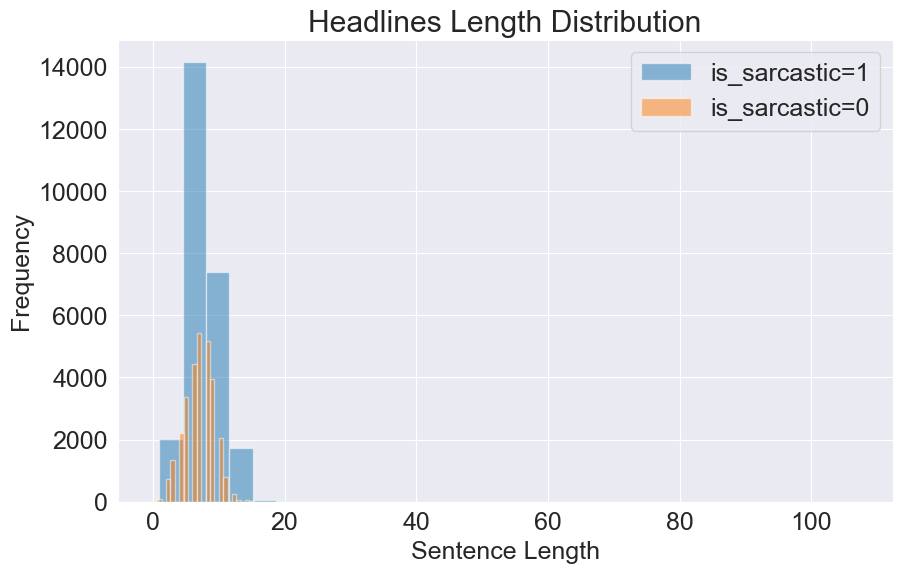

In [13]:
plt.figure(figsize=(10, 6))

for label in data['is_sarcastic'].unique():
    subset = data[data['is_sarcastic'] == label]
    plt.hist(subset['sentence_length'], bins=30, alpha=0.5, label=f'is_sarcastic={label}')

plt.title("Headlines Length Distribution")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

### Interpretasi
* Distribusi panjang kalimat headline mayoritas berada di rentang 5–15 kata, dengan puncak sekitar 8–10 kata untuk kedua kelas (sarcastic dan non-sarcastic).
* Namun, terlihat ada beberapa headline dengan panjang kalimat yang sangat tinggi (lebih dari 40 kata, bahkan >100).
* Ini mencurigakan sebagai outlier, karena headline pada umumnya singkat.
* Perlu dicek ulang apakah data tersebut benar headline, atau ada kesalahan input/entri teks.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16592\4167431656.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




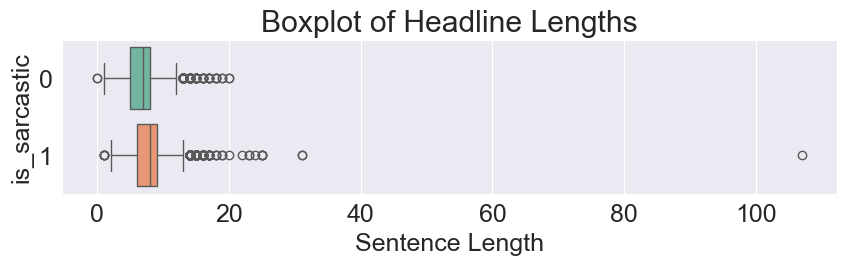

In [14]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=data,
    x="sentence_length",
    y="is_sarcastic",
    hue="is_sarcastic", 
    palette="Set2",
    orient="h",
    dodge=False,
    legend=False
)
plt.title("Boxplot of Headline Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("is_sarcastic")
plt.show()

Tampak bahwa ada outlier yang sangat jauh dari distribusi data

In [15]:
data[data['sentence_length']==107]['headline']

7302    hot wheels ranked number one toy for rolling d...
Name: headline, dtype: object

In [16]:
data.drop(data[data['sentence_length'] == 107].index, inplace = True)
data.reset_index(inplace=True, drop=True)

## Distribusi panjang berita utama: outlier dihapus
- Berita utama setelah pemindahan outlier tidak melebihi batas 20-30 kata
- Mereka sebagian besar berpusat di kisaran 5-10 kata

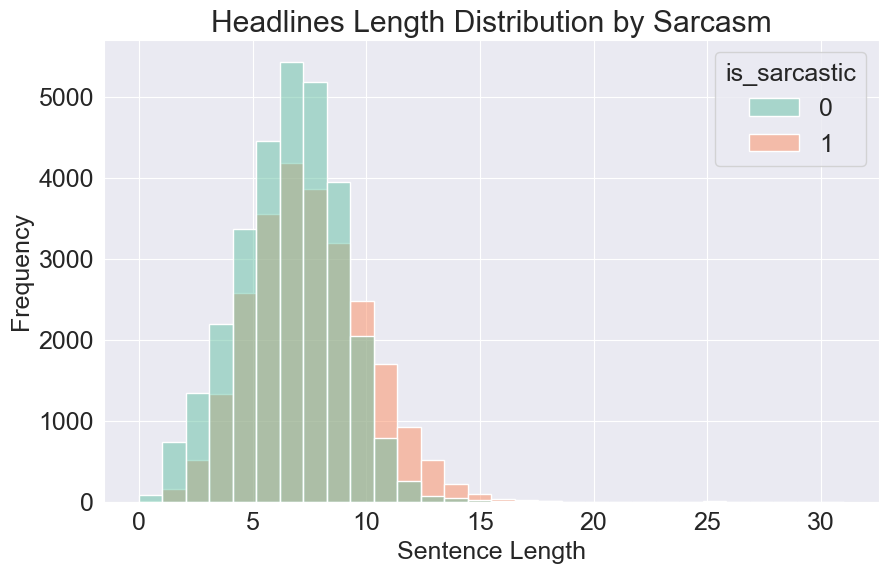

In [17]:

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='sentence_length', hue='is_sarcastic', bins=30, kde=False, palette='Set2')
plt.title('Headlines Length Distribution by Sarcasm')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

### Interpretasi
* Kedua jenis headline (sarkastik dan tidak) memiliki pola distribusi mirip, yaitu distribusi miring ke kanan (right-skewed).
* Titik puncak (modus) berada di panjang kalimat sekitar 7–8 kata.
* Untuk panjang 6–9 kata, jumlah headline tidak sarkastik (hijau) sedikit lebih dominan.
* Namun, mulai dari panjang 10 kata ke atas, proporsi headline sarkastik (merah muda) menjadi lebih tinggi.
* Ini menunjukkan bahwa headline sarkastik cenderung lebih panjang daripada yang tidak sarkastik.
* Headline dengan panjang lebih dari 15 kata hampir seluruhnya berasal dari kategori sarkastik.
* Distribusi sarkastik memiliki ekor lebih panjang, mendukung temuan sebelumnya bahwa headline sarkastik lebih variatif dan cenderung panjang.

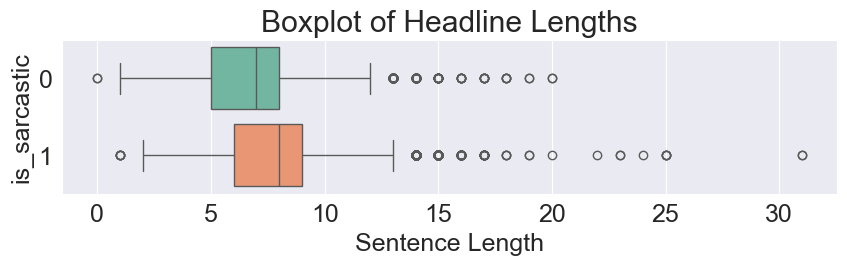

In [25]:
plt.figure(figsize=(10, 2))
sns.boxplot(
    data=data,
    x="sentence_length",
    y="is_sarcastic",
    hue="is_sarcastic",  
    palette="Set2",
    orient="h",
    dodge=False,
    legend=False
)
plt.title("Boxplot of Headline Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("is_sarcastic")
plt.show()

### Interpretasi
* Mayoritas data terpusat antara 4 hingga 12 kata.
* Median headline tidak sarkastik (0) sedikit lebih rendah (sekitar 7 kata).
* Median headline sarkastik (1) lebih tinggi (sekitar 8 kata), menunjukkan headline sarkastik cenderung sedikit lebih panjang.
* Rentang interkuartil (Q1 ke Q3) untuk kedua kelas hampir sama, antara kira-kira 5 hingga 10 kata.
* Ini berarti variabilitas panjang headline relatif mirip di kedua kelas.
* Terdapat lebih banyak outlier ke kanan, terutama pada label sarkastik (1).
* Ini mengindikasikan bahwa headline sarkastik memiliki lebih banyak kalimat panjang ekstrem, bahkan hingga 30 kata.

## Filtering: Temukan kalimat yang berisi angka

In [19]:
data['contains_number'] = data['clean_headline'].apply(lambda x: bool(re.search(r'\d+', x)))
data

,headline,is_sarcastic,entity,clean_headline,sentence_length,contains_number
0,thirtysomething scientists unveil doomsday clo...,1,CARDINAL,thirtysomething scientists unveil doomsday clo...,7,False
1,dem rep. totally nails why congress is falling...,0,"ORG,ORG",dem rep totally nail congress fall short gende...,10,False
2,eat your veggies: 9 deliciously different recipes,0,CARDINAL,eat veggies 9 deliciously different recipes,6,True
3,inclement weather prevents liar from getting t...,1,,inclement weather prevent liar get work,6,False
4,mother comes pretty close to using word 'strea...,1,,mother come pretty close use word stream corre...,8,False
...,...,...,...,...,...,...
55322,american politics in moral free-fall,0,NORP,american politics moral free fall,5,False
55323,america's best 20 hikes,0,"GPE,CARDINAL",america best 20 hike,4,True
55324,reparations and obama,0,,reparations obama,2,False
55325,israeli ban targeting boycott supporters raise...,0,NORP,israeli ban target boycott supporters raise al...,8,False


### Analisis sampel yang berisi jumlah waktu, tanggal atau tipe entitas kardinal
- Angka dalam data teks dapat memiliki implikasi yang berbeda
- Sementara metode preprocessing teks naif menunjukkan bahwa angka -angka harus dihapus bersama dengan karakter khusus
- Jenis entitas dari angka -angka ini harus diidentifikasi untuk mendapatkan implikasinya yang tepat

### 10 Sampel Acak: Entitas Tanggal

In [20]:
data[(data['contains_number']) & (data['sentence_length']<=5) & (data['entity']=='DATE')].sample(10)

,headline,is_sarcastic,entity,clean_headline,sentence_length,contains_number
18220,breaking: adam got a ps4 for christmas,1,DATE,break adam get ps4 christmas,5,True
52928,is 2017 set up for a financial crisis?,0,DATE,2017 set financial crisis,4,True
19010,60 years of sound bites to remember,0,DATE,60 years sound bite remember,5,True
53353,the must see attraction of 2015 in vegas,0,DATE,must see attraction 2015 vegas,5,True
38328,'me decade' celebrates 35th year,1,DATE,decade celebrate 35th year,4,True
2630,"news roundup for august 29, 2017",0,DATE,news roundup august 29 2017,5,True
26906,news roundup for april 17,0,DATE,news roundup april 17,4,True
30478,"news roundup for august 29, 2017",0,DATE,news roundup august 29 2017,5,True
34850,what's ahead for reputation in 2015,0,DATE,ahead reputation 2015,3,True
25483,40-year-old has spiky hair,1,DATE,40 year old spiky hair,5,True


### 10 Sampel Acak: Entitas Waktu

In [21]:
data[(data['contains_number']) & (data['sentence_length']<=5) & (data['entity']=='TIME')].sample(10)

,headline,is_sarcastic,entity,clean_headline,sentence_length,contains_number
40170,donut shop gets weird after 11 a.m.,1,TIME,donut shop get weird 11,5,True
39547,man turns vegetarian for 36 hours,1,TIME,man turn vegetarian 36 hours,5,True
31624,"how to be nicer, healthier and more focused in...",0,TIME,nicer healthier focus 15 minutes,5,True
12158,oven preheated for 16 seconds,1,TIME,oven preheat 16 second,4,True
3409,man turns vegetarian for 36 hours,1,TIME,man turn vegetarian 36 hours,5,True
1800,quake claims 500 hours,1,TIME,quake claim 500 hours,4,True
29312,day chalked up as loss by 10:15 a.m.,1,TIME,day chalk loss 10 15,5,True
18283,5-minute hairstyles -- for real!,0,TIME,5 minute hairstyles real,4,True
29607,quake claims 500 hours,1,TIME,quake claim 500 hours,4,True
54313,oven preheated for 16 seconds,1,TIME,oven preheat 16 second,4,True


### 10 Sampel acak: entitas kardinal

In [22]:
data[(data['contains_number']) & (data['sentence_length']<=5) & (data['entity']=='CARDINAL')].sample(10)

,headline,is_sarcastic,entity,clean_headline,sentence_length,contains_number
34768,education for the world we want (part 2),0,CARDINAL,education world want part 2,5,True
53292,28 secrets of exceptionally productive people,0,CARDINAL,28 secrets exceptionally productive people,5,True
17686,2-d doritos sales lagging,1,CARDINAL,2 doritos sales lag,4,True
41649,"the vergara era, part 1: how we got here",0,CARDINAL,vergara era part 1 get,5,True
47245,10 ways to be authentic online,0,CARDINAL,10 ways authentic online,4,True
6813,"the vergara era, part 1: how we got here",0,CARDINAL,vergara era part 1 get,5,True
31317,"what is vidcon? and why did 20,000 teens show up?",0,CARDINAL,vidcon 20 000 teens show,5,True
52822,8 surprising memory boosters,0,CARDINAL,8 surprise memory boosters,4,True
31293,top 10 college basketball seniors,0,CARDINAL,top 10 college basketball seniors,5,True
32008,top 10 places spring is in bloom,0,CARDINAL,top 10 place spring bloom,5,True


**Inferensi:** Banyak berita utama ini tidak akan masuk akal tanpa waktu, tanggal, atau bahkan nomor kardinal ini. Untuk saat ini kita dapat membiarkan mereka menjadi bagian dari data teks bersih kita.

# Visualisasi kata: Word cloud

In [27]:
sarcastic = data[data['is_sarcastic']==1]['clean_headline'].tolist()
genuine = data[data['is_sarcastic']==0]['clean_headline'].tolist()

## 50 kata teratas: berita utama sarkastik

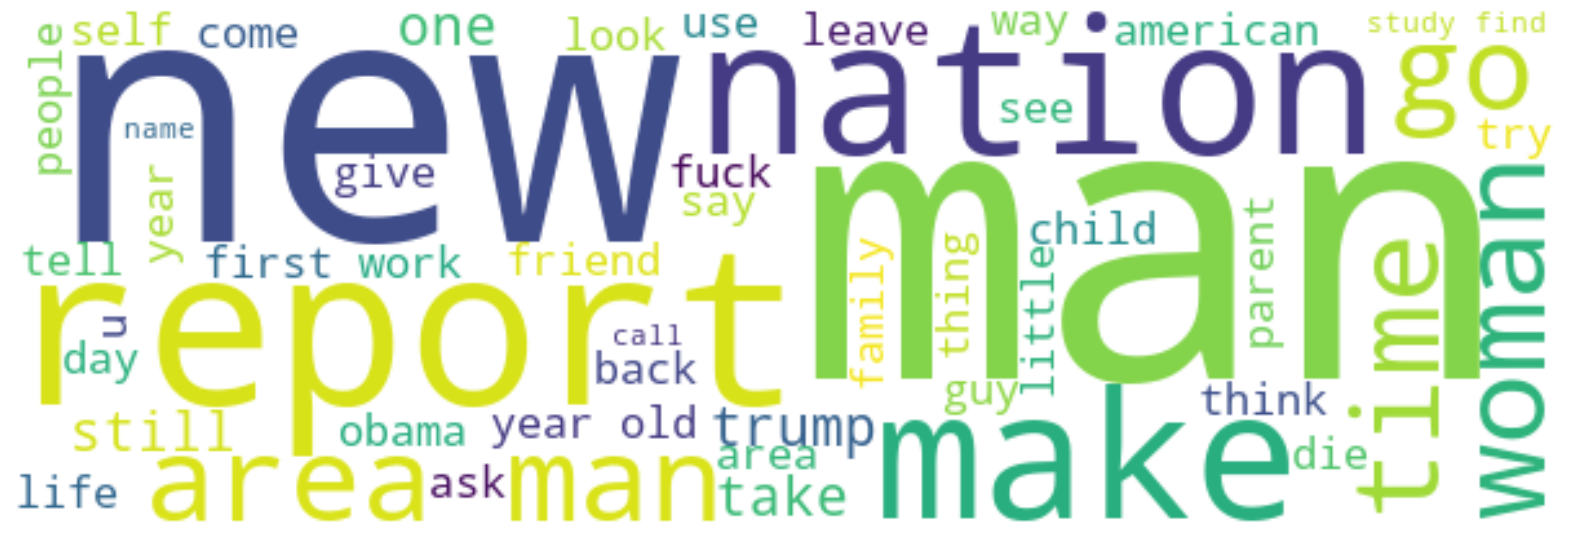

In [28]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(sarcastic))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 50 kata teratas: berita utama asli (genuine)

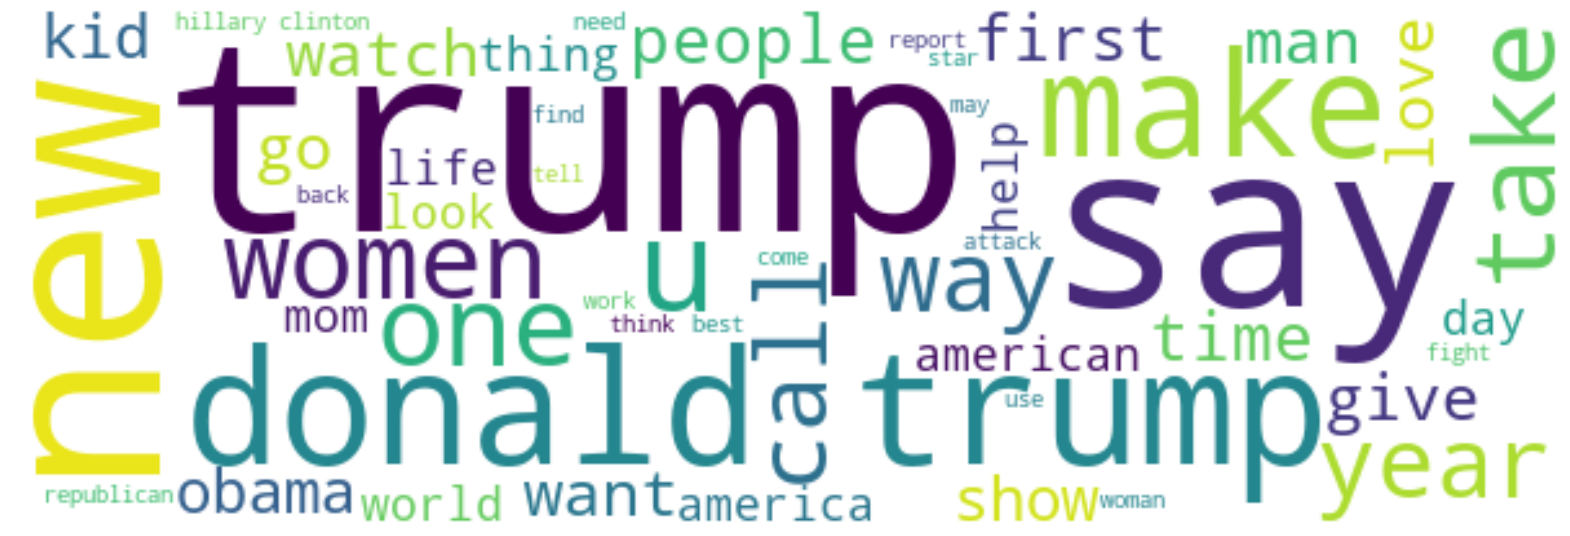

In [29]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(genuine))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Pembangunan model

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [31]:
sentences = data['clean_headline']
label = data['is_sarcastic']

## Train - Validation - Test (80:10:10)

| Jenis Data     | Tujuan                                                                                      |
| -------------- | ------------------------------------------------------------------------------------------- |
| **Train**      | Untuk melatih model                                                                         |
| **Validation** | Untuk menilai performa saat tuning hyperparameter (seperti jumlah neuron, dropout, lr, dsb) |
| **Test**       | Untuk evaluasi akhir yang benar-benar objektif (tidak boleh disentuh saat pelatihan)        |


In [32]:
# 80% data latih, 20% sisanya jadi val + test
X_train, X_val, y_train, y_val = train_test_split(sentences, label, test_size=0.2, stratify=label, random_state=42)

# Dari 20% itu, dibagi dua: 10% val, 10% test
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

## Tokenisasi
- Membagi kalimat menjadi kata -kata
- Menemukan ukuran vocab

In [33]:
max_len = 20
oov_token = '00_V'
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Ukuran Vocab:",vocab_size)

Ukuran Vocab: 20942


## Pengkodean input
- Mengonversi kalimat menjadi token diikuti oleh padded sequences dalam format yang dikodekan
- Ini adalah pengkodean numerik yang ditetapkan untuk setiap kata

In [34]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

## Transformers: Attention is All You Need
- Untuk tujuan masalah klasifikasi, kita hanya akan menggunakan blok encoder dari model Transformers Asli (Encoder-Decoder) yang dirancang untuk masalah urutan
- Gambar di bawah ini dari blog Jay Alamar (untuk penjelasan terperinci: https://jalammar.github.io/illustrated-transformer/)

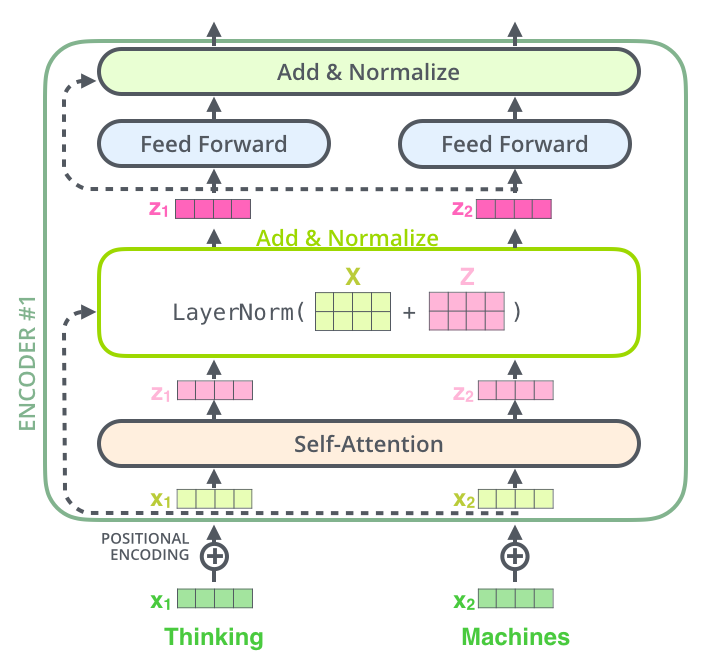

## Multi-Head Attention
- Multi-Head Attention adalah modul untuk mekanisme attention yang berjalan melalui mekanisme attention beberapa kali secara paralel. Output attention independen kemudian digabungkan dan diubah secara linier menjadi dimensi yang diharapkan.
- Mekanisme self attention (diilustrasikan dalam gambar di atas di sebelah gambar blok encoder) digunakan beberapa kali secara paralel dalam multi-head attention
- Multi-Head Attention memungkinkan untuk menghadiri bagian -bagian dari urutan secara berbeda
- Selama self attention, attention score kata dengan sendirinya akan menjadi yang tertinggi, oleh karena itu dengan menggunakan Multi-Head Attention, sebuah kata dapat membangun hubungannya dengan kata-kata lain dalam urutan dengan menghitung attention score dengan mereka secara paralel

In [44]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Definisi Model

In [45]:
# Hitung indeks token maksimum dalam data pelatihan dan validasi
max_index_train = np.max(X_train) if X_train.size > 0 else 0
max_index_val = np.max(X_val) if X_val.size > 0 else 0
max_token_index = max(max_index_train, max_index_val)

# Tetapkan ukuran kosakata berdasarkan indeks token maksimum yang ditemukan
vocab_size = max_token_index + 1

# Tambahkan buffer kecil ke ukuran kosakata agar aman, atau gunakan ukuran sebenarnya dari tokenizer Anda jika tersedia
# vocab_size = max_token_index + 5 # Contoh: menambahkan buffer sebesar 5

print(f"Vocab size berdasarkan data: {vocab_size}")

Vocab size berdasarkan data: 20942


In [46]:
embed_dim = 50
heads = 2
neurons = 32
maxlen = 20
#vocab_size = 20900

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x, training=True)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_2  │ (None, 20, 50)         │     1,048,100 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 20, 50)         │        23,832 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,071,983 (4.09 MB)

 Trainable params: 1,071,983 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

## Pelatihan model

In [48]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [49]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])

Epoch 1/25
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.7644 - loss: 0.4726 - val_accuracy: 0.8596 - val_loss: 0.3259
Epoch 2/25
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9013 - loss: 0.2519 - val_accuracy: 0.8509 - val_loss: 0.3790
Epoch 2: early stopping


# Evaluasi model

## Loss Curve

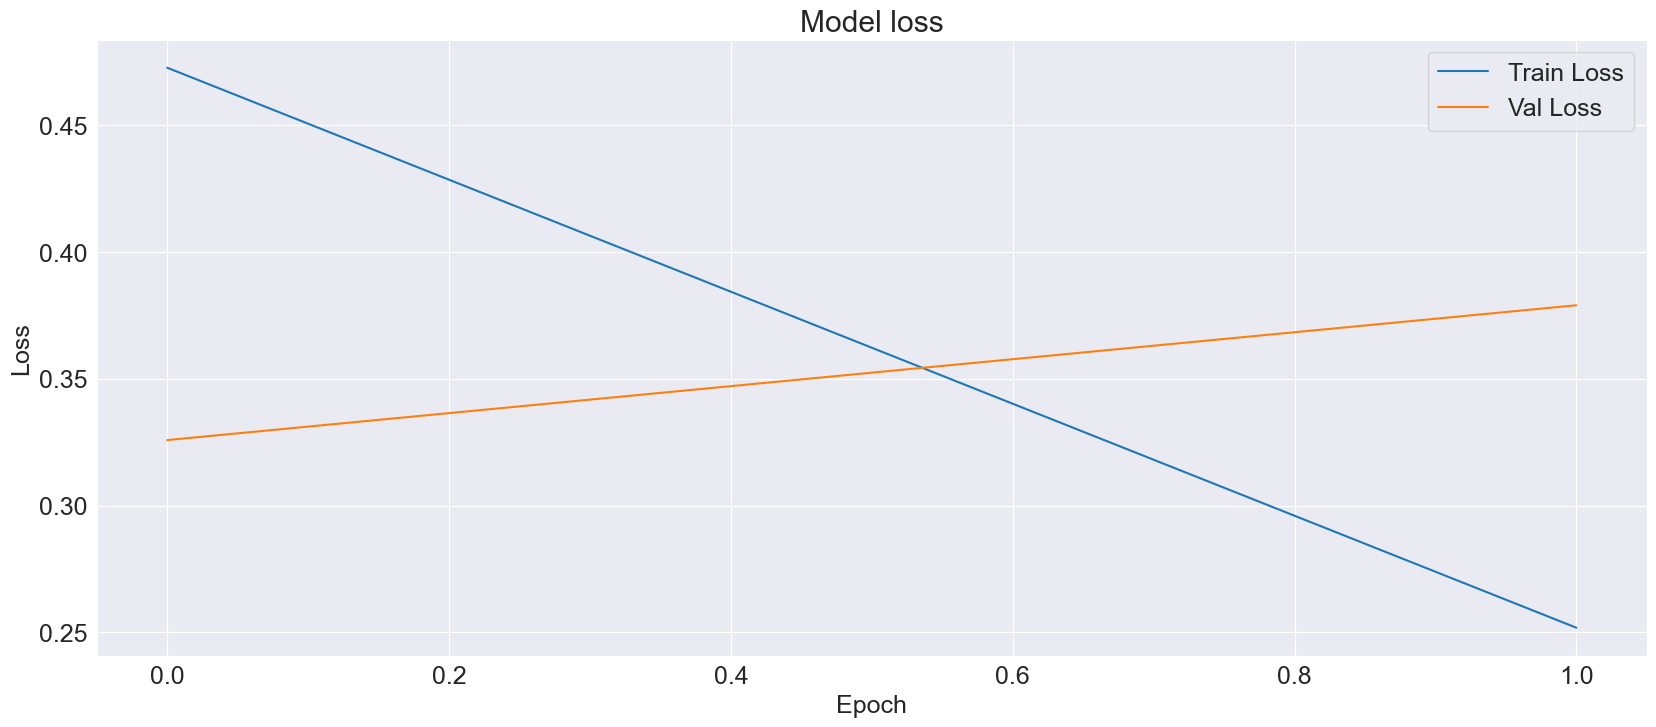

In [50]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.show()

### Interpretasi
1. Perilaku training loss
    * Garis biru (train loss) terus menurun seiring bertambahnya epoch.
    * Artinya, model semakin baik menyesuaikan diri dengan data latih.
2. Perilaku validation loss
    * Garis oranye (val loss) justru meningkat sejak awal training.
    * Ini adalah indikasi bahwa meskipun model belajar pada data latih, performanya pada data validasi memburuk.
3. Tanda overfitting sangat awal
    * Gap antara train loss dan val loss semakin melebar.
    * Model terlalu fokus pada pola di data latih, sehingga gagal generalisasi pada data validasi.
    * Menariknya, hal ini muncul bahkan hanya dalam 1 epoch, yang menandakan overfitting sangat cepat.
4. Implikasi
    * Model berpotensi under-regularized.
    * Perlu strategi seperti:
      - Penambahan dropout atau weight decay.
      - Early stopping dengan patience rendah.
      - Mengurangi learning rate agar pembelajaran lebih stabil.
      - Menambah data augmentasi / pre-processing agar variasi data lebih kaya.
5. Jika ditinjau dari kode
   - `patience=1` pada `EarlyStopping` artinya kalau val_loss tidak membaik dalam 1 epoch saja, training akan langsung berhenti.
   - Karena pada epoch 1 → 2 val_loss justru naik (tidak membaik), maka `EarlyStopping` memutuskan stop di epoch 2, walaupun target awalnya 25 epoch.
   - Jadi ini bukan bug, melainkan memang desain early stopping yang sangat ketat.
6. Kesimpulan
    - Model transformers ini langsung mengalami overfitting sejak awal training, dengan train loss turun konsisten tetapi validation loss justru naik.
    - Perlu penyesuaian regulasi dan strategi training agar performa pada data validasi bisa lebih baik.
    - Early stopping berhasil mencegah overfitting lebih lanjut.
    - Tetapi berhenti terlalu cepat bisa juga berarti model belum sempat belajar cukup lama.
7. Mungkin solusi
   - Kalau ingin memberi model kesempatan belajar lebih lama, tingkatkan patience, misalnya patience=3 atau patience=5.
   - Gunakan juga `ReduceLROnPlateau` agar saat val_loss stagnan, learning rate bisa diturunkan dulu sebelum benar-benar stop.

## Accuracy Curve

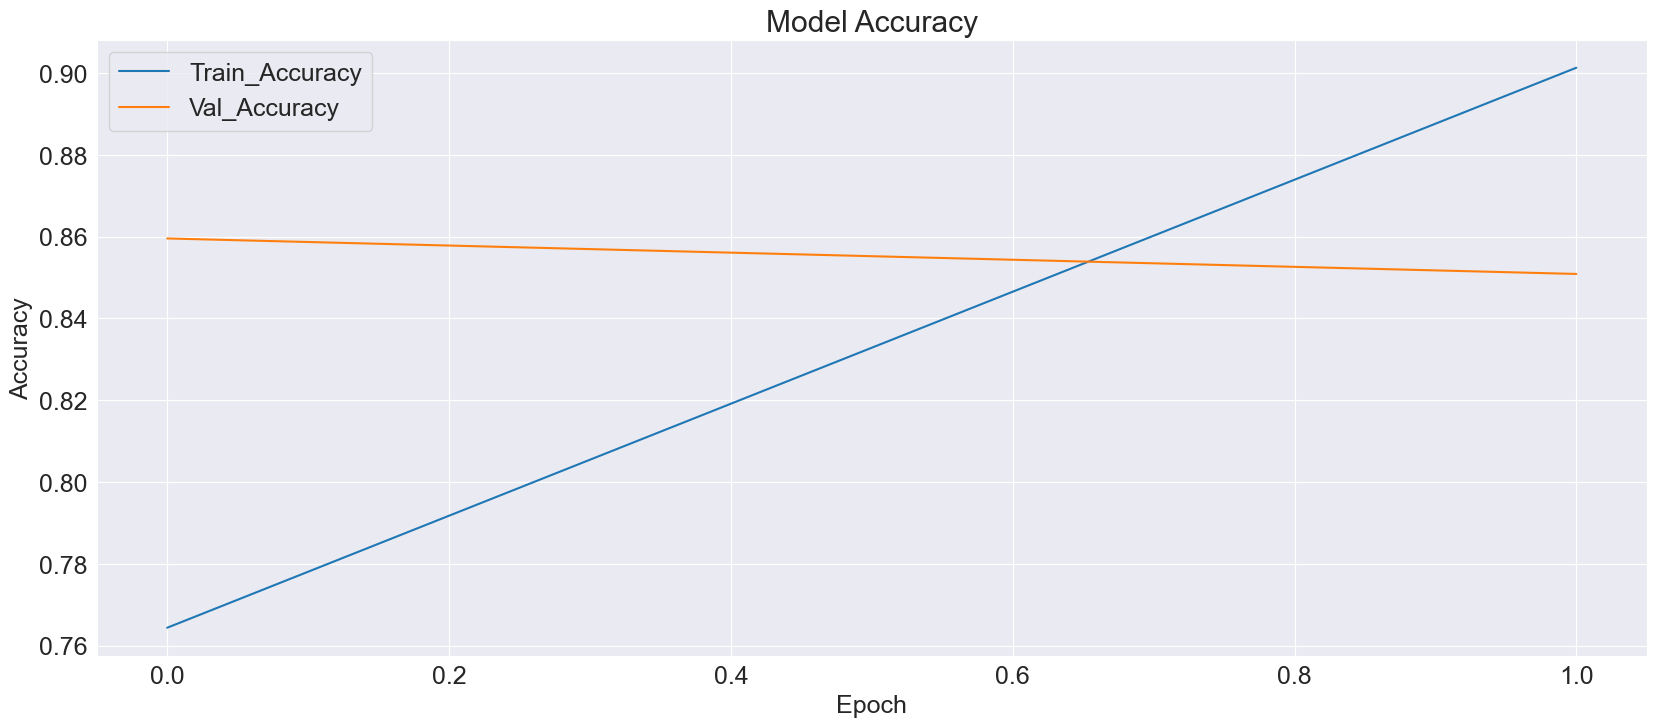

In [51]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_Accuracy', 'Val_Accuracy'], loc='upper left')
plt.show()

### Interpretasi
* Train accuracy meningkat tajam dari sekitar 0.76 → 0.90 hanya dalam 2 epoch. Ini menunjukkan model cepat belajar pada data latih.
* Validation accuracy justru sedikit menurun dari sekitar 0.86 → 0.85, sehingga tidak mengikuti tren training accuracy.
* Ada indikasi overfitting sangat dini yaitu model belajar mengenali pola pada data latih dengan cepat, tetapi tidak mampu mempertahankan kinerja pada data validasi.
* Early stopping bekerja sesuai harapan, menghentikan training lebih cepat untuk mencegah overfitting semakin jauh.
* Tingginya gap antara train accuracy (0.90) dan val accuracy (0.85) setelah hanya 2 epoch menunjukkan model mungkin terlalu kompleks atau learning rate terlalu tinggi.
* Singkatnya, model cepat mencapai akurasi tinggi di data latih, tapi generalisasi ke data validasi kurang baik, sehingga early stopping menghentikan training di epoch ke-2.
* Mungkin solusi
  - Menambah patience agar model diberi kesempatan lebih lama.
  - Menggunakan regularization (dropout, weight decay).
  - Mengaktifkan kembali `ReduceLROnPlateau` supaya LR bisa turun ketika val_loss stagnan.

**Inferensi:** Dalam hal overfitting menggunakan metode tradisional
- Tingkat belajar yang rendah
- regularisasi L1-L2
- Dropout
- Neuron yang lebih rendah di lapisan MLP
- berhenti lebih awal
- dll.

## Metrik Klasifikasi
- Karena penting untuk tidak salah mengklasifikasikan berita utama asli sebagai berita utama sarkastik, kita juga akan melihat skor ROC AUC untuk menghindari kesalahan klasifikasi berita utama sebagai berita utama sarkastik

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

### Kurva ROC

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   


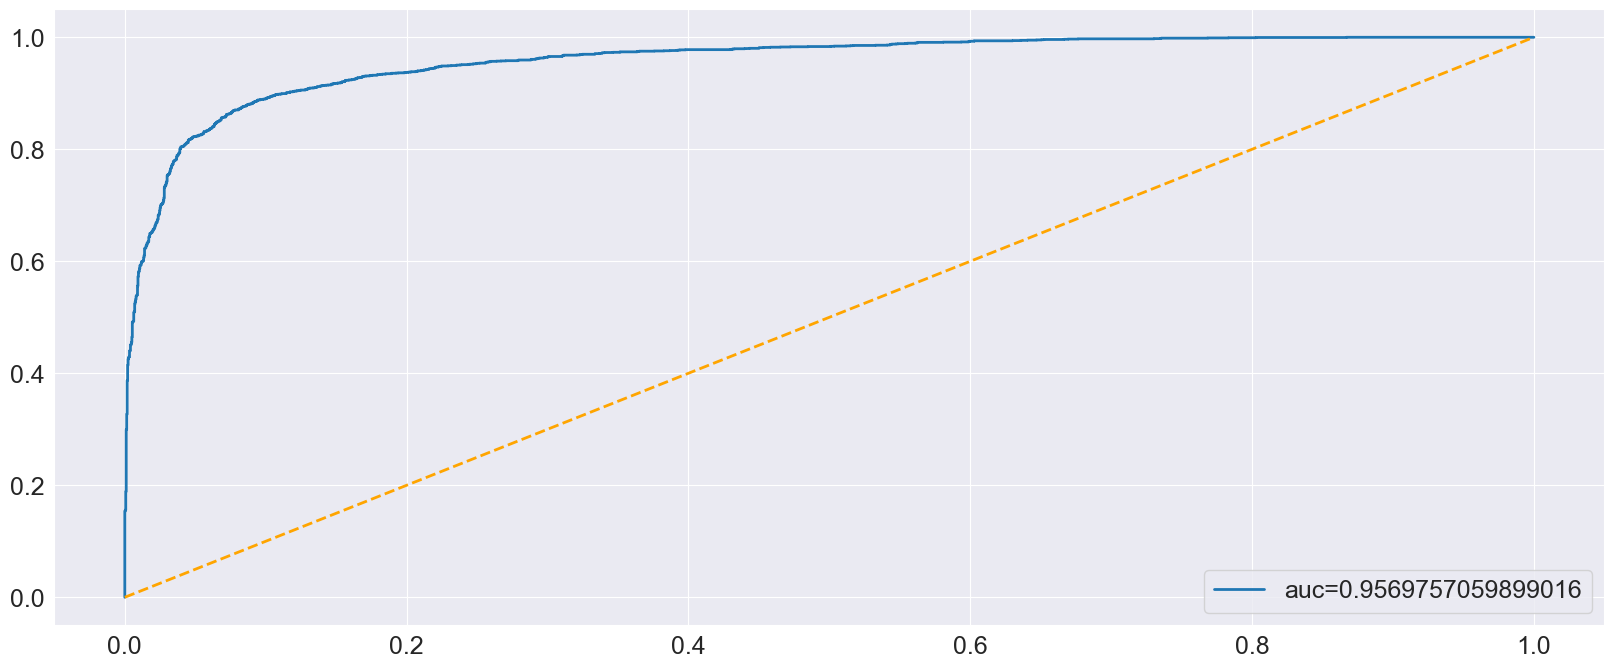

In [53]:
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

#### Interpretasi
* Kurva ROC (garis biru) berada jauh di atas garis diagonal acak (garis oranye). Ini menunjukkan bahwa model mampu membedakan kelas positif dan negatif dengan baik.
* AUC = 0.9569 → termasuk kategori sangat baik (mendekati 1). Artinya, ada sekitar 95,7% peluang model memberikan skor probabilitas lebih tinggi pada sampel positif dibanding sampel negatif.
* Model memiliki performa klasifikasi yang sangat tinggi dalam membedakan kelas, jauh lebih baik daripada prediksi acak.
* Nilai AUC yang mendekati 1 menandakan model stabil dan efektif untuk digunakan pada data ini.

### Classification report

In [54]:
y_pred[y_pred>=5] = 1
y_pred[y_pred<5] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2997
           1       0.89      0.89      0.89      2536

    accuracy                           0.90      5533
   macro avg       0.90      0.90      0.90      5533
weighted avg       0.90      0.90      0.90      5533



#### Interpretasi
* Model mampu mengklasifikasikan data dengan tingkat akurasi 90%, yang berarti 9 dari 10 prediksi benar.
* Macro avg & weighted avg = 0.90 → menunjukkan tidak ada bias yang signifikan antar kelas (performanya merata).
* Model ini cukup stabil dan seimbang dalam mengenali kedua kelas.
* Tidak ada kelas yang terlalu diabaikan (recall seimbang), juga tidak ada prediksi yang terlalu banyak salah (precision tinggi).
* Dengan akurasi 90%, model bisa dianggap sangat baik untuk tugas klasifikasi biner pada dataset ini.

### Confusion matrix

<Axes: >

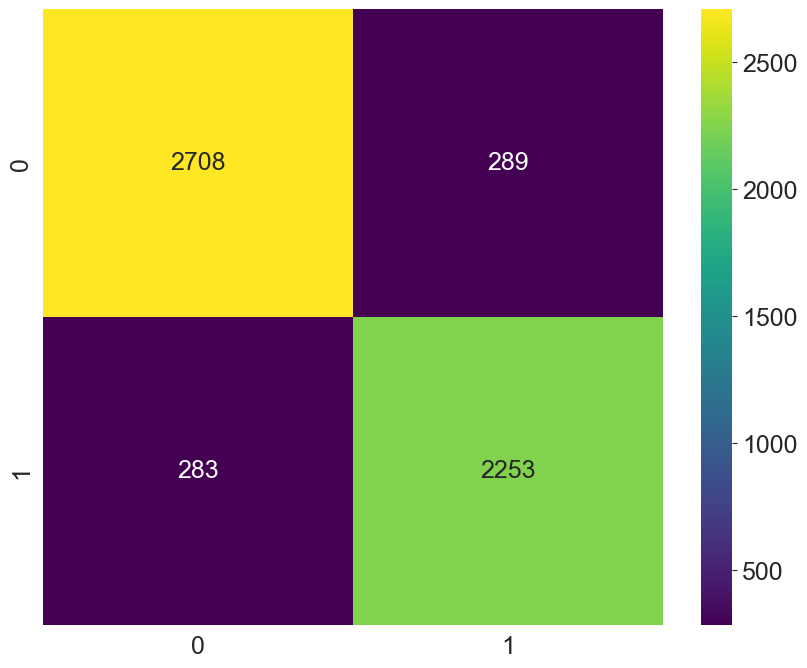

In [55]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g',cmap='viridis')

#### Interpretasi
* Model cukup seimbang antara mendeteksi kelas 0 dan kelas 1.
* Hal ini terlihat dari jumlah kesalahan FN (283) dan FP (289) yang hampir sama.
* Dari total 5533 sampel, model melakukan prediksi benar sebanyak 2708 + 2253 = 4961 kasus (90%), sesuai dengan classification report.
* Kesalahan model tidak berat sebelah, baik kelas 0 maupun kelas 1 punya error yang hampir sama.
* Ini menandakan bahwa dataset relatif seimbang, sehingga model tidak bias ke salah satu kelas.

# Eksplorasi untuk membandingkan dengan model lain

## Preprocessing dan Embedding

In [56]:
embed_dim = 50
maxlen = 20

# Untuk layer embedding gabungan token + posisi
embedding_layer = TokenAndPositionEmbedding(maxlen=maxlen, vocab_size=vocab_size, embed_dim=embed_dim)

# Untuk input embedding untuk semua data
X_train_embed = embedding_layer(tf.convert_to_tensor(X_train)).numpy()
X_val_embed = embedding_layer(tf.convert_to_tensor(X_val)).numpy()
X_test_embed = embedding_layer(tf.convert_to_tensor(X_test)).numpy()


In [57]:
X_train.shape

(44261, 20)

In [58]:
X_train_embed.shape

(44261, 20, 50)

Untuk model seperti SVM, Naive Bayes, dan Random Forest yang tidak menerima tensor 3D, kita akan gunakan:

In [59]:
X_train_flat = X_train_embed.mean(axis=1)
X_val_flat = X_val_embed.mean(axis=1)
X_test_flat = X_test_embed.mean(axis=1)

## Definisi Model-Model Pembanding

In [96]:
import time
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam

results = []

### Evaluate Model

In [97]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, epochs=5, is_sklearn=False):
    start = time.time()
    if is_sklearn:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        try:
            auc = roc_auc_score(y_test, y_proba)
        except:
            auc = np.nan
    else:
        model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])
        model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_val_embed, y_val))
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        _, accuracy = model.evaluate(X_test, y_test, verbose=0)
        f1 = f1_score(y_test, y_pred)
    end = time.time()
    results.append({"Model": name, "Accuracy": accuracy, "f1-score": f1,"Training Time": round(end - start, 2)})

In [98]:
def Tevaluate_model(name, model, X_train, y_train, X_test, y_test, epochs=5, is_sklearn=False):
    start = time.time()
    if is_sklearn:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        try:
            auc = roc_auc_score(y_test, y_proba)
        except:
            auc = np.nan
    else:
        model.compile(loss="binary_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])
        model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_val, y_val))
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        _, accuracy = model.evaluate(X_test, y_test, verbose=0)
        f1 = f1_score(y_test, y_pred)
    end = time.time()
    results.append({"Model": name, "Accuracy": accuracy, "f1-score": f1, "Training Time": round(end - start, 2)})

### Transformer Encoder (model utama)

In [99]:
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x, training=True)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
transformer_model = Model(inputs, outputs)
Tevaluate_model("Transformer", transformer_model, X_train, y_train, X_test, y_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   


### LSTM

In [100]:
lstm_model = Sequential([
    Input(shape=(maxlen, embed_dim)),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
evaluate_model("LSTM", lstm_model, X_train_embed, y_train, X_test_embed, y_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   


### CNN1D

In [101]:
cnn_model = Sequential([
    Input(shape=(maxlen, embed_dim)),
    Conv1D(128, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])
evaluate_model("CNN-1D", cnn_model, X_train_embed, y_train, X_test_embed, y_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


### MLP

In [102]:
mlp_model = Sequential([
    Input(shape=(maxlen, embed_dim)),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
evaluate_model("MLP", mlp_model, X_train_embed, y_train, X_test_embed, y_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


### Naive Bayes

In [103]:
nb_model = GaussianNB()
evaluate_model("Naive Bayes", nb_model, X_train_flat, y_train, X_test_flat, y_test, is_sklearn=True)

### SVM

In [104]:
svm_model = SVC(kernel='linear')
evaluate_model("SVM", svm_model, X_train_flat, y_train, X_test_flat, y_test, is_sklearn=True)

### Random Forest

In [105]:
rf_model = RandomForestClassifier(n_estimators=100)
evaluate_model("Random Forest", rf_model, X_train_flat, y_train, X_test_flat, y_test, is_sklearn=True)

### Bidirectional LSTM

In [106]:
bi_lstm_model = Sequential([
    Input(shape=(maxlen, embed_dim)),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])
evaluate_model("Bi-LSTM", bi_lstm_model, X_train_embed, y_train, X_test_embed, y_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   


### Adaboost

In [107]:
ada_model = AdaBoostClassifier(n_estimators=100)
evaluate_model("AdaBoost", ada_model, X_train_flat, y_train, X_test_flat, y_test, is_sklearn=True)

### XGBoost

In [108]:
xgb_model = XGBClassifier(n_estimators=100, eval_metric='logloss')
evaluate_model("XGBoost", xgb_model, X_train_flat, y_train, X_test_flat, y_test, is_sklearn=True)

## Hasil Akhir

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print(results_df)

           Model  Accuracy  f1-score  Training Time
0    Transformer  0.937647  0.931151         101.62
6  Random Forest  0.912525  0.900041          36.50
9        XGBoost  0.777878  0.745074           0.83
2         CNN-1D  0.706127  0.614143          20.26
1           LSTM  0.651907  0.559671          47.99
7        Bi-LSTM  0.644316  0.555355          52.80
8       AdaBoost  0.602205  0.483939          28.55
5            SVM  0.601663  0.388457         206.85
3            MLP  0.594253  0.471889          13.96
4    Naive Bayes  0.558648  0.485245           0.03


In [110]:
results_df

,Model,Accuracy,f1-score,Training Time
0,Transformer,0.937647,0.931151,101.62
6,Random Forest,0.912525,0.900041,36.50
9,XGBoost,0.777878,0.745074,0.83
2,CNN-1D,0.706127,0.614143,20.26
1,LSTM,0.651907,0.559671,47.99
7,Bi-LSTM,0.644316,0.555355,52.80
8,AdaBoost,0.602205,0.483939,28.55
5,SVM,0.601663,0.388457,206.85
3,MLP,0.594253,0.471889,13.96
4,Naive Bayes,0.558648,0.485245,0.03


### Interpretasi
1. Performa Terbaik – Transformer & Random Forest
    - Transformer unggul mutlak dengan akurasi 94% & f1 93%. Cocok jika akurasi adalah prioritas utama, meskipun butuh waktu latih lebih lama.
    - Random Forest hampir setara (91% akurasi, f1 90%) dengan training time 3x lebih cepat. Cocok untuk praktik industri yang butuh kompromi antara akurasi tinggi & efisiensi.
2. Performa Menengah – XGBoost, CNN-1D
    - XGBoost punya akurasi lebih rendah (77%), tapi sangat efisien (0.83 detik). Cocok untuk eksperimen cepat atau baseline yang ringan.
    - CNN-1D masih kalah dibanding tree-based, akurasi hanya 70%. Bisa relevan jika data berbentuk sekuens/seri waktu.
3. Kurang Optimal – LSTM & Bi-LSTM
    - Baik LSTM maupun Bi-LSTM tidak memberikan hasil baik (65% akurasi).
    - Waktu latih juga lama (48–53 detik), sehingga tidak efisien untuk dataset ini.
4. Performa Rendah – AdaBoost, SVM, MLP, Naive Bayes
    - AdaBoost & MLP akurasi sekitar 60%, tidak cukup baik.
    - SVM terburuk dalam efisiensi, yaitu akurasi hanya 60% dengan waktu latih paling lama (207 detik).
    - Naive Bayes super cepat (0.03 detik), tapi akurasi sangat rendah (56%). Cocok hanya sebagai baseline pembanding.
5. Kesimpulan
   - Best Overall → Transformer (akurasi tertinggi, cocok untuk aplikasi dengan fokus presisi, meski waktu latih lebih lama).
   - Best Trade-off → Random Forest (hampir sama bagus dengan Transformer, jauh lebih cepat, cocok untuk deployment industri).
   - Best Efficiency → XGBoost (hasil tidak sebaik RF/Transformer, tapi sangat cepat; berguna untuk prototyping cepat).
   - Kurang Rekomendasi → LSTM, Bi-LSTM, CNN-1D (tidak lebih baik dari model tree, meski lebih kompleks).
   - Baseline → Naive Bayes & MLP (rendah akurasi, tapi bisa dipakai sebagai pembanding dasar).

## Perbandingan Akurasi Model

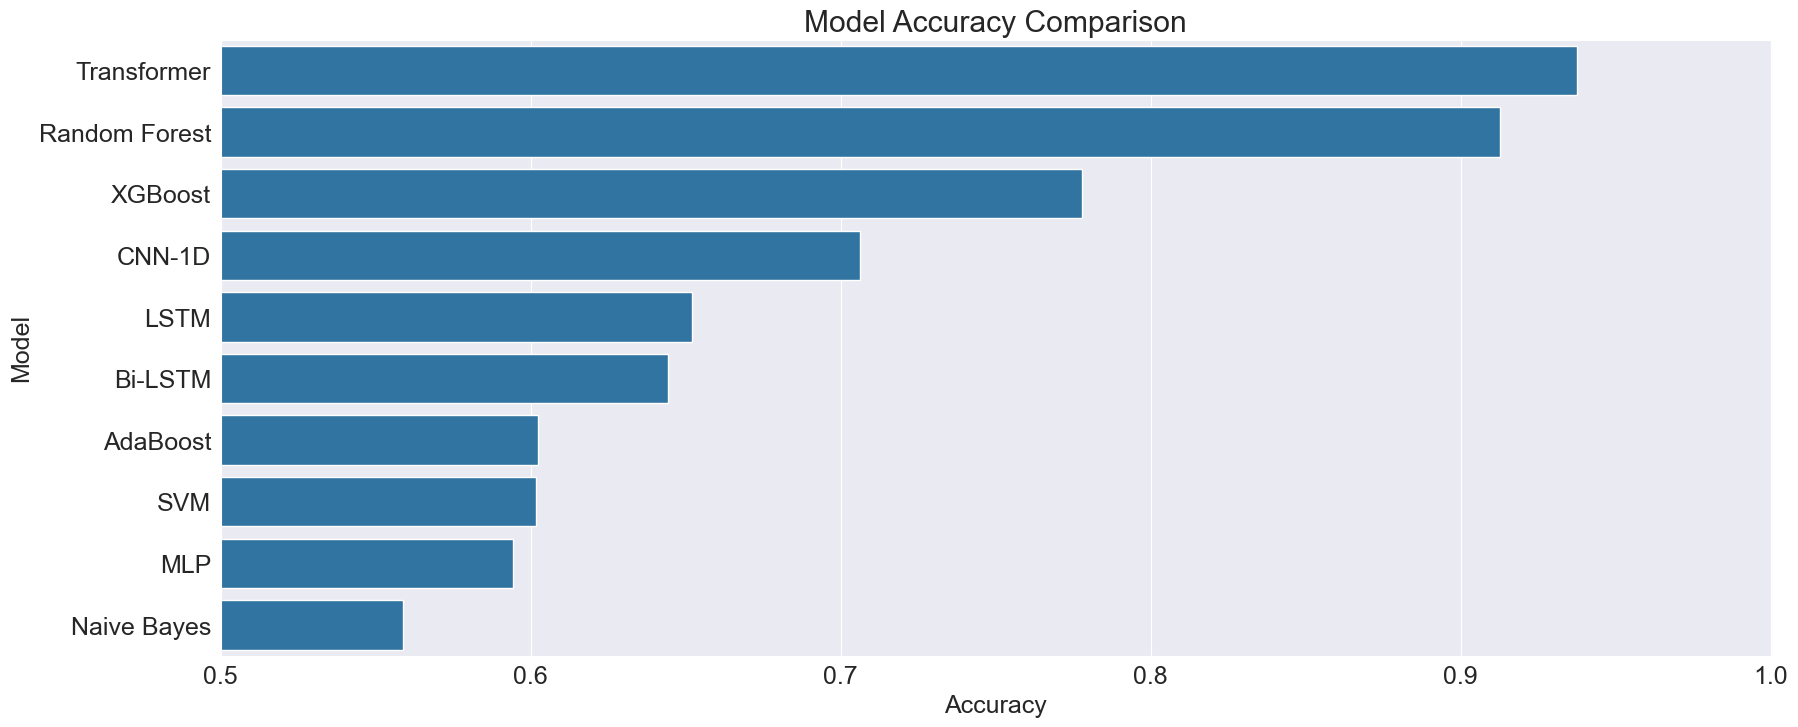

In [111]:
sns.barplot(data=results_df, x="Accuracy", y="Model")
plt.title("Model Accuracy Comparison")
plt.xlim(0.5, 1.0)
plt.show()

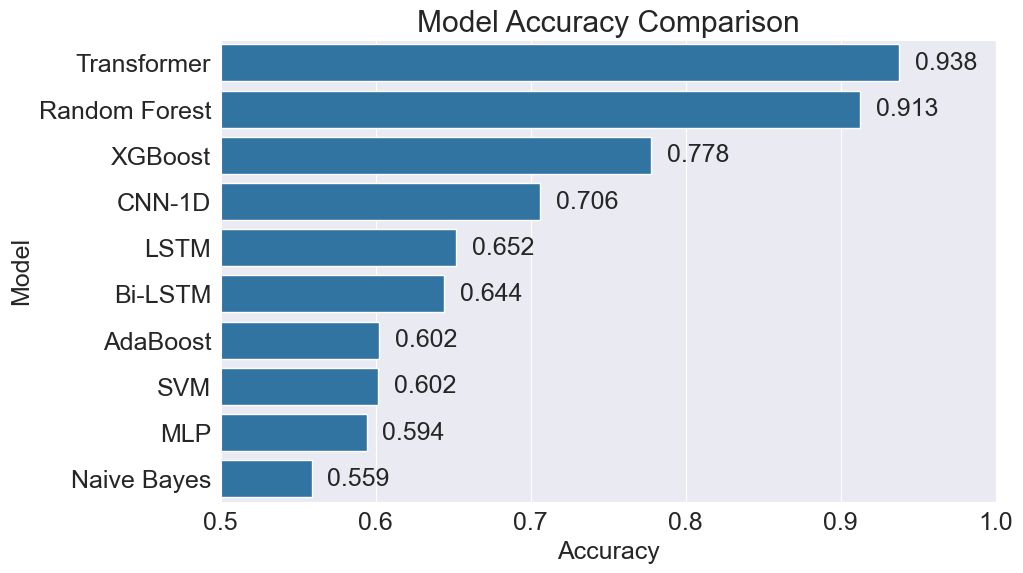

In [112]:
plt.figure(figsize=(10,6))
ax = sns.barplot(data=results_df, x="Accuracy", y="Model")

# Tambahkan label di ujung bar
for p in ax.patches:
    ax.text(
        p.get_width() + 0.01,   # posisi x (sedikit di kanan bar)
        p.get_y() + p.get_height()/2,  # posisi y (tengah bar)
        f"{p.get_width():.3f}", # format angka
        va="center"
    )

plt.title("Model Accuracy Comparison")
plt.xlim(0.5, 1.0)
plt.show()

## Perbandingan F1-Score Model

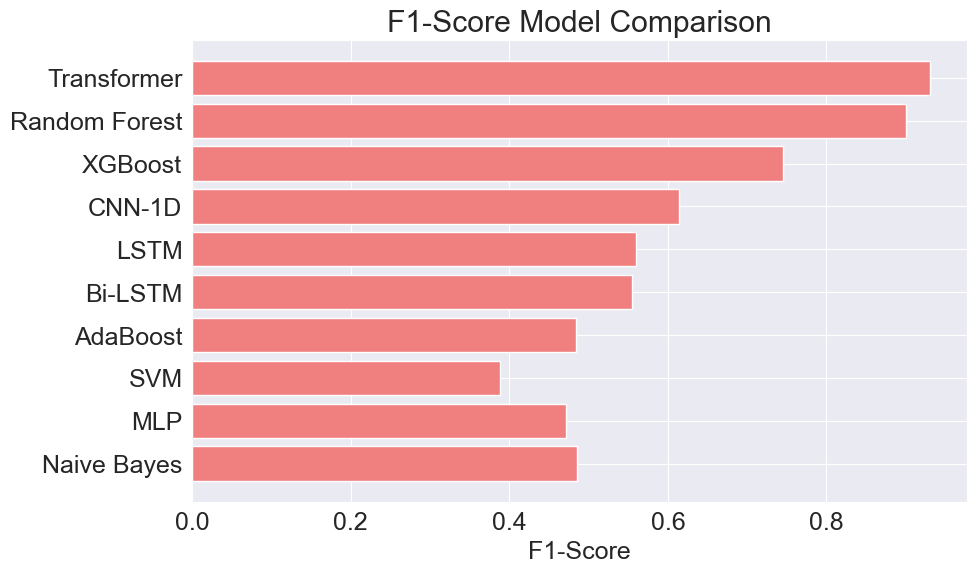

In [113]:
plt.figure(figsize=(10,6))
plt.barh(results_df["Model"], results_df["f1-score"], color="lightcoral")
plt.xlabel("F1-Score")
plt.title("F1-Score Model Comparison")
plt.gca().invert_yaxis()
plt.show()

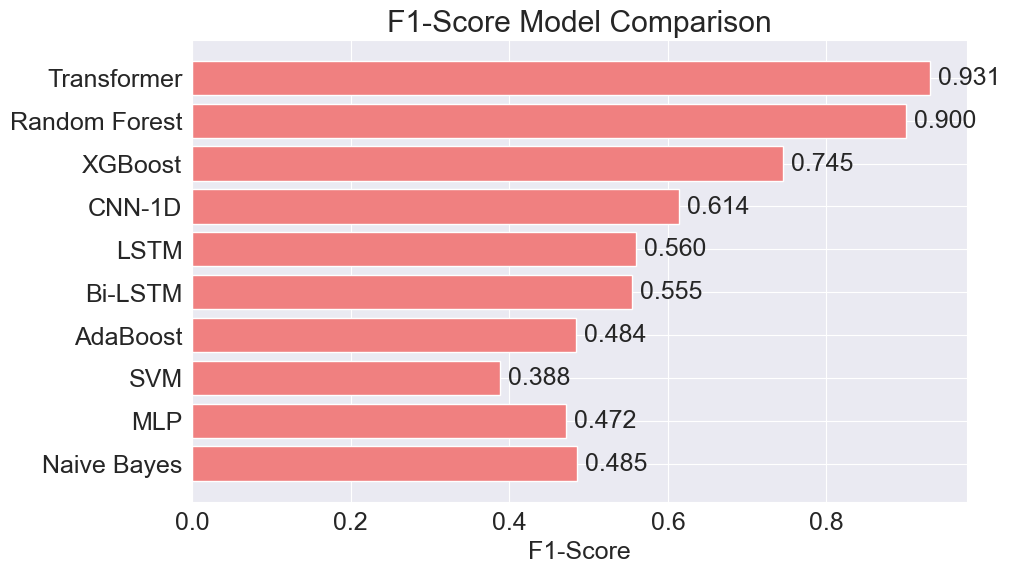

In [114]:
plt.figure(figsize=(10,6))
bars = plt.barh(results_df["Model"], results_df["f1-score"], color="lightcoral")

# Tambahkan label di ujung bar
for bar in bars:
    plt.text(
        bar.get_width() + 0.01,  # posisi x (kanan bar)
        bar.get_y() + bar.get_height()/2,  # posisi y (tengah bar)
        f"{bar.get_width():.3f}", # format angka
        va="center"
    )

plt.xlabel("F1-Score")
plt.title("F1-Score Model Comparison")
plt.gca().invert_yaxis()
plt.show()

## Trade-off: Akurasi vs Waktu Training

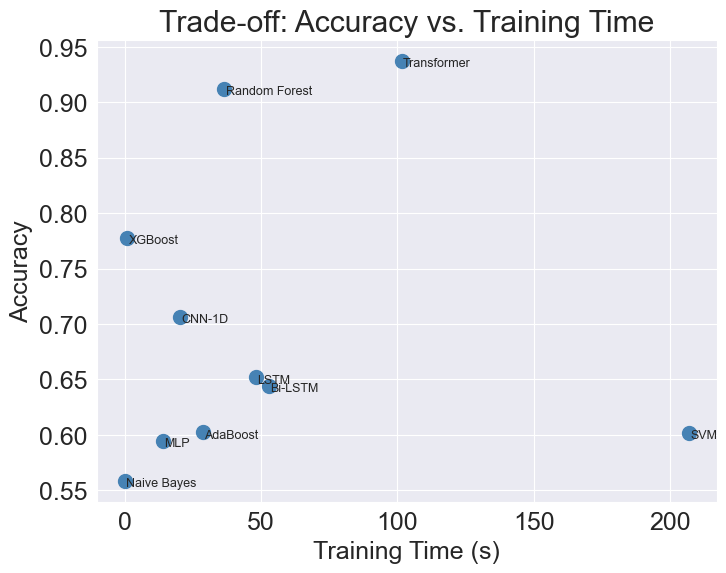

In [115]:
plt.figure(figsize=(8,6))
plt.scatter(results_df["Training Time"], results_df["Accuracy"], s=100, c="steelblue")
for i, row in results_df.iterrows():
    plt.text(row["Training Time"]+0.5, row["Accuracy"]-0.005, row["Model"], fontsize=9)
plt.xlabel("Training Time (s)")
plt.ylabel("Accuracy")
plt.title("Trade-off: Accuracy vs. Training Time")
plt.show()

### Interpretasi
1. Model dengan Akurasi Tinggi
    - Transformer: Mencapai akurasi tertinggi (0.94), tetapi membutuhkan waktu training yang relatif lama (100 detik). Cocok bila tujuan utama adalah akurasi maksimal, meski butuh lebih banyak resource.
    - Random Forest: Akurasi tinggi (0.91) dengan waktu training jauh lebih rendah (40 detik). Ini adalah opsi paling efisien bila kita ingin kompromi antara performa dan waktu.
2. Model dengan Akurasi Menengah
    - XGBoost: Akurasi cukup tinggi (0.78) dengan waktu training sangat singkat (<5 detik). Ini membuatnya unggul bila kita ingin model cepat dilatih namun tetap presisi.
    - CNN-1D: Akurasi sekitar 0.71 dengan waktu training menengah (20 detik). Layak bila dataset berbasis sekuens/gambar 1D.
    - LSTM & Bi-LSTM: Keduanya akurasinya hampir sama (0.65) dengan waktu training sedang (50 detik). Tidak terlalu unggul dibanding model lain dalam grafik ini.
3. Model dengan Akurasi Rendah
    - SVM: Akurasi sekitar 0.60 dengan waktu training paling lama (200 detik). Ini kurang efisien karena butuh banyak waktu namun akurasinya rendah.
    - Naive Bayes, MLP, AdaBoost: Akurasinya rendah (0.55–0.60) dengan waktu training singkat, sehingga hanya cocok untuk baseline atau perbandingan.
4. Kesimpulan
   - Jika akurasi adalah prioritas utama pilih Transformer.
   - Jika efisiensi (akurasi cukup baik + waktu singkat) pilih Random Forest atau XGBoost.
   - Jika resource terbatas gunakan Naive Bayes / AdaBoost / MLP untuk baseline.
   - SVM tampak tidak seimbang, karena butuh waktu lama tapi akurasinya rendah.

## Perbandingan Waktu Latih Model

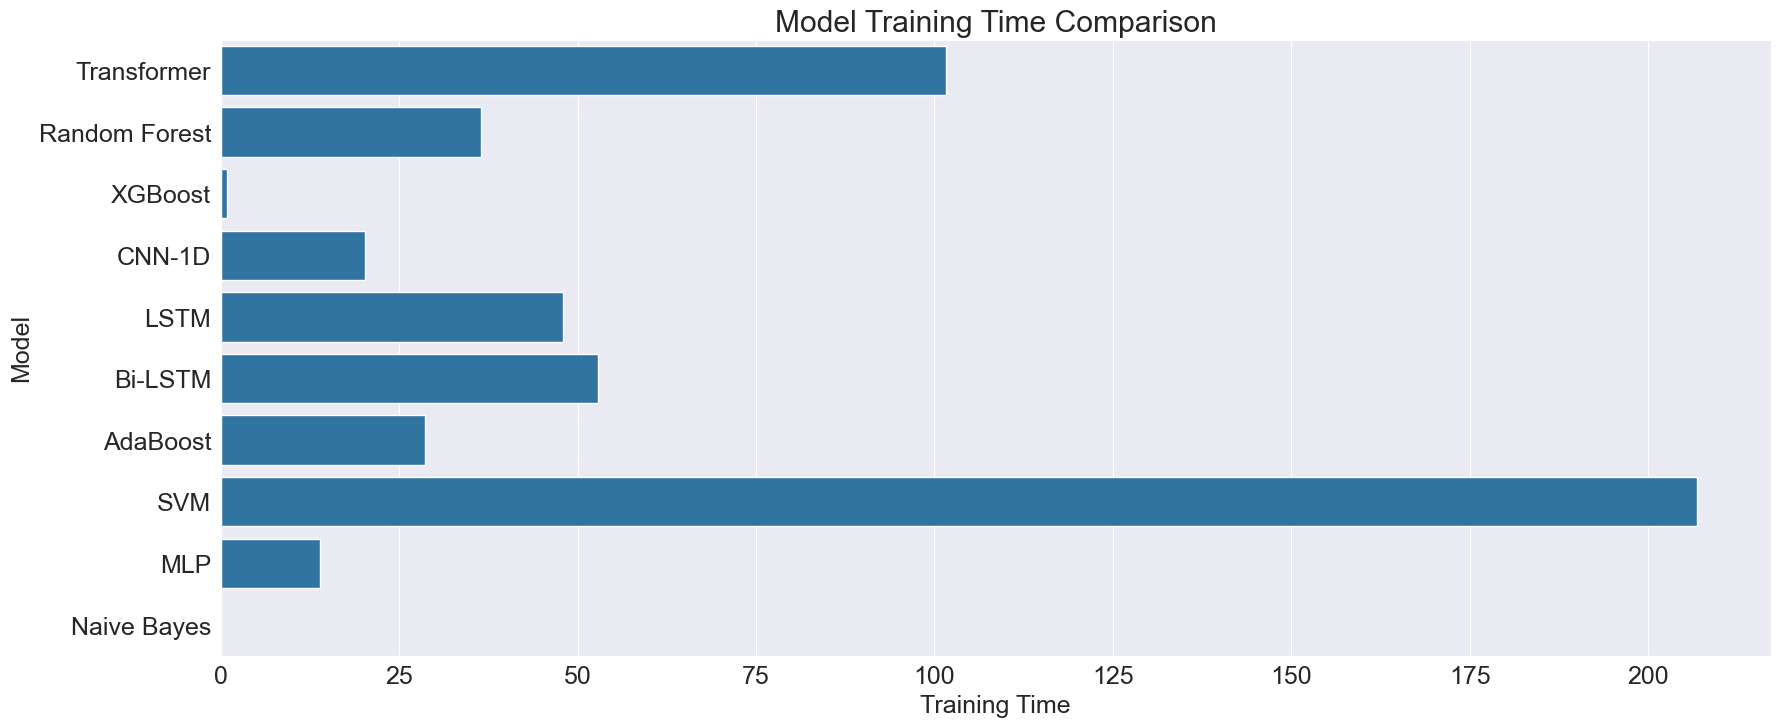

In [116]:
sns.barplot(data=results_df, x="Training Time", y="Model")
plt.title("Model Training Time Comparison")
plt.show()

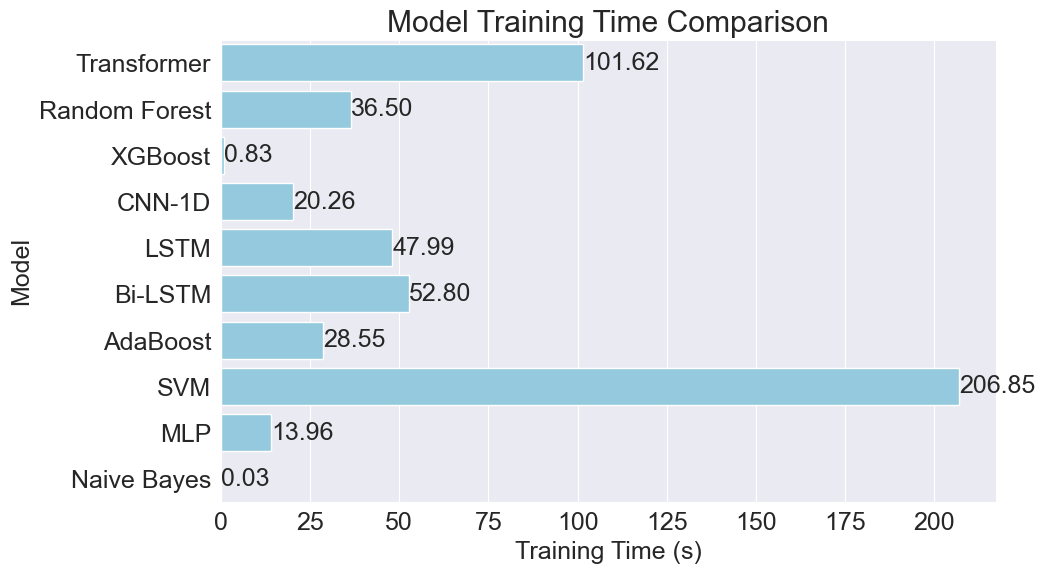

In [117]:
plt.figure(figsize=(10,6))
ax = sns.barplot(data=results_df, x="Training Time", y="Model", color="skyblue")

# Tambahkan label di ujung bar
for p in ax.patches:
    ax.text(
        p.get_width() + 0.05,   # posisi x (sedikit di kanan bar)
        p.get_y() + p.get_height()/2,  # posisi y (tengah bar)
        f"{p.get_width():.2f}", # format angka 2 desimal
        va="center"
    )

plt.title("Model Training Time Comparison")
plt.xlabel("Training Time (s)")
plt.show()

# Kesimpulan
Secara keseluruhan, perbandingan menunjukkan bahwa Transformer memberikan performa terbaik dengan akurasi dan f1-score tertinggi meskipun membutuhkan waktu pelatihan yang cukup lama. Random Forest tampil sebagai pilihan paling seimbang dengan akurasi tinggi dan waktu pelatihan jauh lebih singkat, sementara XGBoost menjadi alternatif yang efisien ketika kecepatan menjadi prioritas utama. Model lain seperti CNN-1D, LSTM, dan Bi-LSTM masih mampu menangkap pola, namun performanya tertinggal. Sementara itu, SVM terbukti tidak efisien karena membutuhkan waktu sangat lama dengan hasil yang relatif rendah. Dengan demikian, pemilihan model dapat disesuaikan dengan kebutuhan, Transformer untuk akurasi maksimal, Random Forest untuk keseimbangan, dan XGBoost untuk efisiensi.

# Thank You